In [76]:
import os

PI = "pi@192.168.11.89"
DEST = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle"

FILES = [
    "/home/pi/teplota_pradelna.csv",
    "/home/pi/teplota_log.csv",
    "/home/pi/netatmo/climate.log",
    "/home/pi/netatmo/netatmo_climate.csv",
]

scp_cmd = "scp " + " ".join(f"{PI}:{f}" for f in FILES) + f' "{DEST}"'
os.system(scp_cmd)


0

## Zobrazení poslední hodiny teplota_log.csv

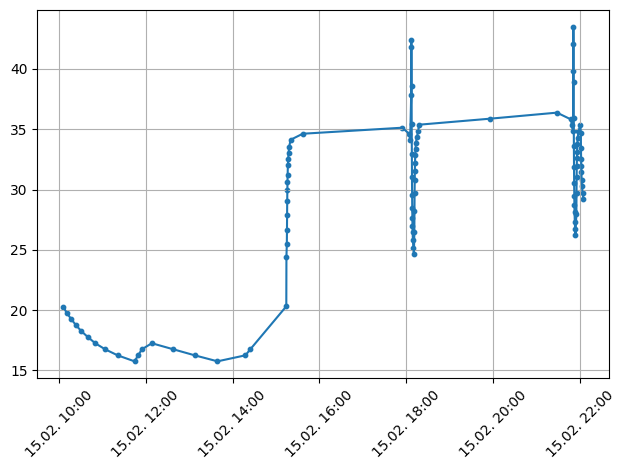

In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import zoneinfo

ax = plt.gca()
ax.xaxis.set_major_formatter(
    mdates.DateFormatter('%d.%m. %H:%M', tz=zoneinfo.ZoneInfo("Europe/Prague"))
)
plt.xticks(rotation=45)

df = pd.read_csv("teplota_log.csv", header=None, names=["Time", "Value"])
df["Time"] = (
    pd.to_datetime(df["Time"], errors="coerce") 
    .dt.tz_localize("Europe/Prague") # ← DŮLEŽITÉ 
)
              
df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
df = df.dropna().sort_values("Time").drop_duplicates("Time")

df_plot = df[df["Time"] >= df["Time"].max() - pd.Timedelta(hours=12)]

plt.plot(df_plot["Time"], df_plot["Value"])
plt.scatter(df_plot["Time"], df_plot["Value"], s=10)
plt.grid()
plt.tight_layout()
plt.show()


In [78]:
 
df.tail(10)


,Time,Value
1625,2026-02-15 22:00:19+01:00,35.375
1626,2026-02-15 22:01:02+01:00,34.687
1627,2026-02-15 22:01:13+01:00,33.437
1628,2026-02-15 22:01:24+01:00,32.562
1629,2026-02-15 22:01:35+01:00,31.937
1630,2026-02-15 22:01:46+01:00,31.437
1631,2026-02-15 22:02:08+01:00,30.812
1632,2026-02-15 22:02:40+01:00,30.250
1633,2026-02-15 22:03:24+01:00,29.750
1634,2026-02-15 22:04:29+01:00,29.250


## Vytvoření df_netatmo ze souboru netatmo_data.csv

In [79]:
import pandas as pd

# Cesta k souboru
path = "/Users/Marek/Library/Mobile Documents/com~apple~CloudDocs/Documents/GitHub/Teploty_kotle/netatmo_climate.csv"

# Načtení dat - tentokrát bez skiprows, protože data začínají hned
df_netatmo = pd.read_csv(path)

# 1) převod z UNIX sekund na datetime
df_netatmo["timestamp"] = ( 
    pd.to_datetime(df_netatmo["timestamp"], unit="s", utc=True) 
    .dt.tz_convert("Europe/Prague") 
)

# 2) pokud chceš formátovaný textový sloupec
df_netatmo["timestamp_str"] = df_netatmo["timestamp"].dt.strftime("%d.%m.%Y %H:%M:%S")


# Ukázka dat
df_netatmo.tail(10)


,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,timestamp_str
1843,2026-02-15 21:15:06+01:00,22.0,-5.2,22,True,1012.2,15.02.2026 21:15:06
1844,2026-02-15 21:20:08+01:00,22.0,-5.3,22,True,1012.2,15.02.2026 21:20:08
1845,2026-02-15 21:25:08+01:00,22.0,-5.3,22,True,1012.0,15.02.2026 21:25:08
1846,2026-02-15 21:30:08+01:00,22.1,-5.3,22,True,1011.8,15.02.2026 21:30:08
1847,2026-02-15 21:35:08+01:00,22.1,-5.3,22,True,1011.7,15.02.2026 21:35:08
1848,2026-02-15 21:45:09+01:00,22.1,-5.3,22,True,1011.6,15.02.2026 21:45:09
1849,2026-02-15 21:50:12+01:00,22.1,-5.3,22,True,1011.6,15.02.2026 21:50:12
1850,2026-02-15 21:55:10+01:00,22.1,-5.3,22,True,1011.5,15.02.2026 21:55:10
1851,2026-02-15 22:00:13+01:00,22.1,-5.3,22,True,1011.4,15.02.2026 22:00:13
1852,2026-02-15 22:05:08+01:00,22.1,-5.3,21,False,1011.3,15.02.2026 22:05:08


## Zobrazení ekvitermních křivek

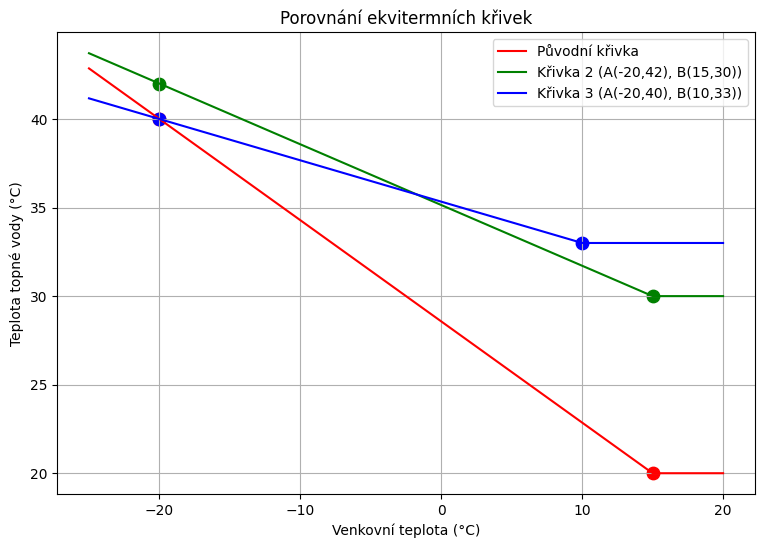

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Původní křivka
def hokejka(temp_in):
    if temp_in <= 15:
        return -0.571428 * temp_in + 28.5714
    else:
        return 20

# 2) Druhá křivka (A(-20,42), B(15,30) – tvoje stará verze)
def hokejka2(temp_in):
    if temp_in <= 15:
        return -0.342857 * temp_in + 35.143
    else:
        return 30

# 3) Nová křivka podle bodů A(-20,40) a B(10,33) 
def hokejka3(temp_in):
    if temp_in <= 10:
        return -0.233333 * temp_in + 35.333333
    else:
        return 33

# Data pro graf
temps_in = np.linspace(-25, 20, 200)
temps_out_1 = [hokejka(t) for t in temps_in]
temps_out_2 = [hokejka2(t) for t in temps_in]
temps_out_3 = [hokejka3(t) for t in temps_in]

# Vykreslení
plt.figure(figsize=(9, 6))
plt.plot(temps_in, temps_out_1, label="Původní křivka", color="red")
plt.plot(temps_in, temps_out_2, label="Křivka 2 (A(-20,42), B(15,30))", color="green")
plt.plot(temps_in, temps_out_3, label="Křivka 3 (A(-20,40), B(10,33))", color="blue")

# Body původní křivky
plt.scatter([-20, 15], [40, 20], color="red", s=80)

# Body křivky 2
plt.scatter([-20, 15], [42, 30], color="green", s=80)

# Body křivky 3
plt.scatter([-20, 10], [40, 33], color="blue", s=80)

plt.title("Porovnání ekvitermních křivek")
plt.xlabel("Venkovní teplota (°C)")
plt.ylabel("Teplota topné vody (°C)")
plt.grid(True)
plt.legend()

plt.show()


### Výpočet boiler_water_2 z temp_outdoor v df_netatmo, který byl vytvořen výše

In [81]:
import pandas as pd


# 3) Nová křivka podle bodů A(-20,15) a B(40,33) 
def hokejka3(temp_in):
    if temp_in <= 10:
        return -0.233333 * temp_in + 35.333333
    else:
        return 33

# Sloupec Boiler_water
# df_netatmo["Boiler_water"] = df_netatmo["temp_outdoor"].apply(hokejka)

# Nový sloupec Boiler_water_2
df_netatmo["Boiler_water_2"] = df_netatmo["temp_outdoor"].apply(hokejka3)

# Ukázka posledních 10 řádků
df_netatmo.tail(10)


,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,timestamp_str,Boiler_water_2
1843,2026-02-15 21:15:06+01:00,22.0,-5.2,22,True,1012.2,15.02.2026 21:15:06,36.546665
1844,2026-02-15 21:20:08+01:00,22.0,-5.3,22,True,1012.2,15.02.2026 21:20:08,36.569998
1845,2026-02-15 21:25:08+01:00,22.0,-5.3,22,True,1012.0,15.02.2026 21:25:08,36.569998
1846,2026-02-15 21:30:08+01:00,22.1,-5.3,22,True,1011.8,15.02.2026 21:30:08,36.569998
1847,2026-02-15 21:35:08+01:00,22.1,-5.3,22,True,1011.7,15.02.2026 21:35:08,36.569998
1848,2026-02-15 21:45:09+01:00,22.1,-5.3,22,True,1011.6,15.02.2026 21:45:09,36.569998
1849,2026-02-15 21:50:12+01:00,22.1,-5.3,22,True,1011.6,15.02.2026 21:50:12,36.569998
1850,2026-02-15 21:55:10+01:00,22.1,-5.3,22,True,1011.5,15.02.2026 21:55:10,36.569998
1851,2026-02-15 22:00:13+01:00,22.1,-5.3,22,True,1011.4,15.02.2026 22:00:13,36.569998
1852,2026-02-15 22:05:08+01:00,22.1,-5.3,21,False,1011.3,15.02.2026 22:05:08,36.569998


## Graf z df_netatmo

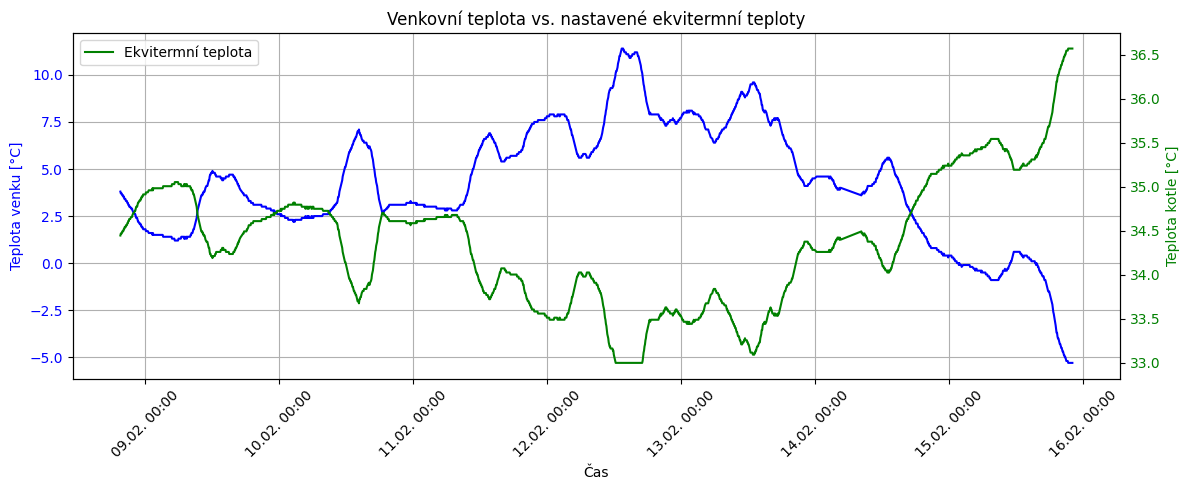

In [82]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Posun času o 1 hodinu
df_netatmo["timestamp_shifted"] = df_netatmo["timestamp"] + pd.to_timedelta(1, "h")

fig, ax = plt.subplots(figsize=(12, 5))

# Hlavní osa – venkovní teplota
ax.plot(df_netatmo["timestamp_shifted"], df_netatmo["temp_outdoor"],
        color="blue", label="Teplota venku")
ax.set_ylabel("Teplota venku [°C]", color="blue")
ax.tick_params(axis="y", labelcolor="blue")

# Vedlejší osa – teplota kotle
ax2 = ax.twinx()
ax2.plot(df_netatmo["timestamp_shifted"], df_netatmo["Boiler_water_2"],
         color="green", label="Ekvitermní teplota")
ax2.set_ylabel("Teplota kotle [°C]", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Titulek a popisky
ax.set_title("Venkovní teplota vs. nastavené ekvitermní teploty")
ax.set_xlabel("Čas")

# Formátování osy X
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
ax.tick_params(axis='x', rotation=45)

# Legenda
ax2.legend(loc="upper left")

ax.grid(True)
fig.tight_layout()
plt.show()




## Starý soubor teplota_log_old1

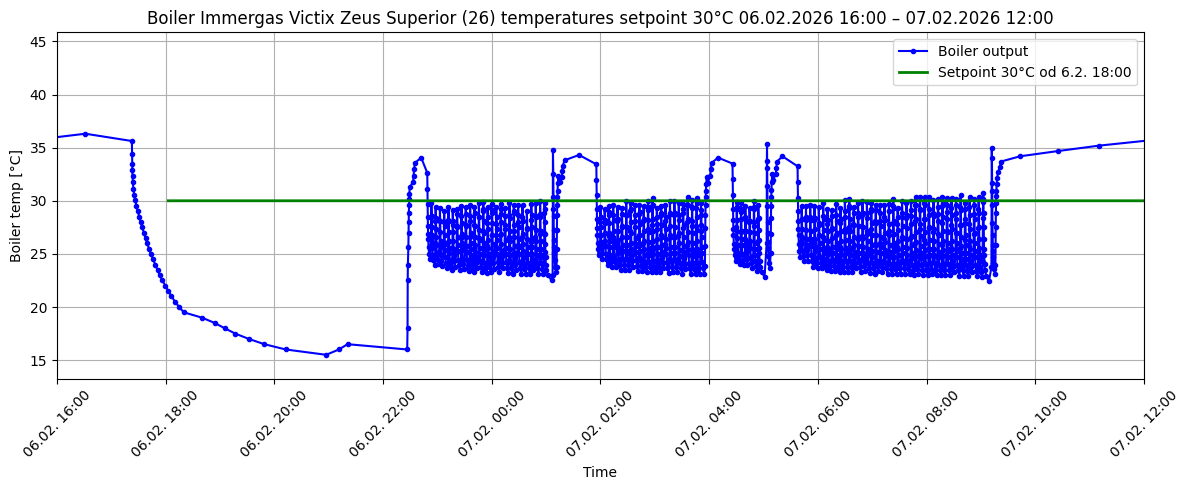

In [83]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Nastavení žádané teploty kotle na 30°C od 6.2. v 18:00 do 7.2. v 9:30 poté bylo nastaveno 33°C

df_old = pd.read_csv("teplota_log_old1.csv", header=None, names=["Time", "Value"])
df_old["Time"] = pd.to_datetime(df_old["Time"], errors="coerce")
df_old["Value"] = pd.to_numeric(df_old["Value"], errors="coerce")
df_old = df_old.dropna().sort_values("Time").drop_duplicates("Time")

# --- RUČNÍ NASTAVENÍ ČASOVÉHO OKNA ---
start_time = pd.Timestamp("2026-02-06 16:00:00")
end_time   = pd.Timestamp("2026-02-07 12:00")

plt.figure(figsize=(12,5))
ax = plt.gca()

# Kotel
ax.plot(df_old["Time"], df_old["Value"], marker=".", color="blue", label="Boiler output")

# --- Zelená křivka začínající až 6.2. v 18:00 
start_const = pd.Timestamp("2026-02-06 18:00:00")
mask = df_old["Time"] >= start_const
ax.plot(df_old.loc[mask, "Time"], [30] * mask.sum(), color="green", linewidth=2, label="Setpoint 30°C od 6.2. 18:00")

# Netatmo – původní křivka
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water"], color="red", label="Ekviterm temp")

# Netatmo – nová křivka (Boiler_water_2)
# ax.plot(df_netatmo["time_local"], df_netatmo["Boiler_water_2"], color="green", label="Ekviterm temp 2")

# --- APLIKACE ČASOVÉHO OKNA NA GRAF ---
ax.set_xlim(start_time, end_time)

# Formát osy X
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
plt.xticks(rotation=45)

plt.title(f"Boiler Immergas Victix Zeus Superior (26) temperatures setpoint 30°C {start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}")

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [84]:
# timezone-aware
start_tz = pd.Timestamp("2026-02-14 10:00:00", tz="Europe/Prague")
end_tz   = pd.Timestamp("2026-02-15 22:30:00", tz="Europe/Prague")

# timezone-naive
start_naive = start_tz.tz_localize(None)
end_naive   = end_tz.tz_localize(None)


## Nový soubor raspberry teplota_log.csv

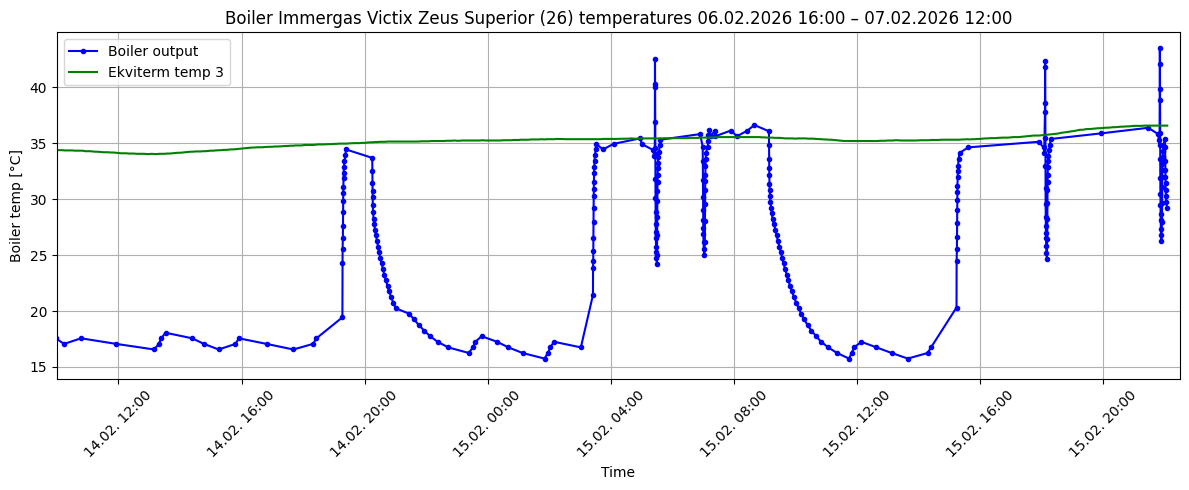

In [85]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import zoneinfo

# --- ČASOVÉ OKNO (musí mít stejnou zónu jako Netatmo) ---
# start_time = pd.Timestamp("2026-02-14 10:00:00", tz="Europe/Prague")
# end_time   = pd.Timestamp("2026-02-15 09:00:00", tz="Europe/Prague")

plt.figure(figsize=(12,5))
ax = plt.gca()

# ---------------------------------------------------------
# 1) KOTEL – převedeme do stejné zóny jako Netatmo
# ---------------------------------------------------------
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

if df["Time"].dt.tz is None:
    df["Time"] = df["Time"].dt.tz_localize("Europe/Prague")
else:
    df["Time"] = df["Time"].dt.tz_convert("Europe/Prague")

ax.plot(
    df["Time"],
    df["Value"],
    marker=".",
    color="blue",
    label="Boiler output"
)

# ---------------------------------------------------------
# 2) NETATMO – timestamp je UTC → převedeme do Europe/Prague
# ---------------------------------------------------------
df_netatmo["time_local"] = (
    pd.to_datetime(df_netatmo["timestamp"], unit="s", utc=True)
    .dt.tz_convert("Europe/Prague")
)

ax.plot(
    df_netatmo["time_local"],
    df_netatmo["Boiler_water_2"],
    color="green",
    label="Ekviterm temp 3"
)

# ---------------------------------------------------------
# 3) ČASOVÉ OKNO
# ---------------------------------------------------------
ax.set_xlim(start_tz, end_tz)

# ---------------------------------------------------------
# 4) FORMÁT OSY X – nastavíme Europe/Prague
# ---------------------------------------------------------
ax.xaxis.set_major_formatter(
    mdates.DateFormatter('%d.%m. %H:%M', tz=zoneinfo.ZoneInfo("Europe/Prague"))
)

plt.xticks(rotation=45)

plt.title(
    f"Boiler Immergas Victix Zeus Superior (26) temperatures "
    f"{start_time:%d.%m.%Y %H:%M} – {end_time:%d.%m.%Y %H:%M}"
)

ax.set_xlabel("Time")
ax.set_ylabel("Boiler temp [°C]")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



## Import souboru Climate.csv

In [86]:
import pandas as pd

df_climate = pd.read_csv(path)

df_climate["time_local"] = (
    pd.to_datetime(df_climate["timestamp"], unit="s", utc=True)
    .dt.tz_convert("Europe/Prague")
)

df_climate["time_local_str"] = df_climate["time_local"].dt.strftime("%d.%m.%Y %H:%M:%S")

df_climate.tail(10)





,timestamp,temp_indoor,temp_outdoor,setpoint,boiler,pressure,time_local,time_local_str
1843,1771186506,22.0,-5.2,22,True,1012.2,2026-02-15 21:15:06+01:00,15.02.2026 21:15:06
1844,1771186808,22.0,-5.3,22,True,1012.2,2026-02-15 21:20:08+01:00,15.02.2026 21:20:08
1845,1771187108,22.0,-5.3,22,True,1012.0,2026-02-15 21:25:08+01:00,15.02.2026 21:25:08
1846,1771187408,22.1,-5.3,22,True,1011.8,2026-02-15 21:30:08+01:00,15.02.2026 21:30:08
1847,1771187708,22.1,-5.3,22,True,1011.7,2026-02-15 21:35:08+01:00,15.02.2026 21:35:08
1848,1771188309,22.1,-5.3,22,True,1011.6,2026-02-15 21:45:09+01:00,15.02.2026 21:45:09
1849,1771188612,22.1,-5.3,22,True,1011.6,2026-02-15 21:50:12+01:00,15.02.2026 21:50:12
1850,1771188910,22.1,-5.3,22,True,1011.5,2026-02-15 21:55:10+01:00,15.02.2026 21:55:10
1851,1771189213,22.1,-5.3,22,True,1011.4,2026-02-15 22:00:13+01:00,15.02.2026 22:00:13
1852,1771189508,22.1,-5.3,21,False,1011.3,2026-02-15 22:05:08+01:00,15.02.2026 22:05:08


## Setpoint a teplota kotle

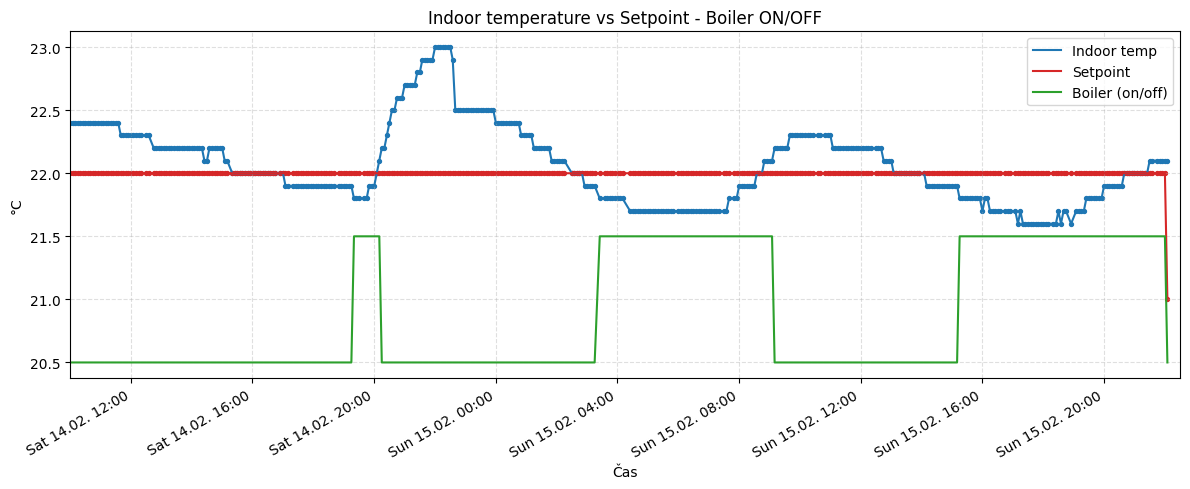

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Převod timestamp → datetime + posun o 1 hodinu
df_climate["time"] = pd.to_datetime(df_climate["timestamp"], unit="s") + pd.to_timedelta(1, "h")

# --- ČASOVÉ OKNO (naivní, protože df_climate["time"] je také naivní) ---


# -----------------------------
# GRAF
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 5))

# Indoor temp
ax.plot(df_climate["time"], df_climate["temp_indoor"], label="Indoor temp",
        color="tab:blue", linewidth=1.5)
ax.scatter(df_climate["time"], df_climate["temp_indoor"], s=8, color="tab:blue")

# Setpoint
ax.plot(df_climate["time"], df_climate["setpoint"], label="Setpoint",
        color="tab:red", linewidth=1.5)
ax.scatter(df_climate["time"], df_climate["setpoint"], s=8, color="tab:red")

# Boiler (0/1) posunutý nahoru
ax.plot(df_climate["time"], df_climate["boiler"] + 20.5,
        label="Boiler (on/off)", color="tab:green", linewidth=1.5)

# --- ČASOVÉ OKNO ---
ax.set_xlim(start_naive, end_naive)

ax.set_title("Indoor temperature vs Setpoint - Boiler ON/OFF")
ax.set_xlabel("Čas")
ax.set_ylabel("°C")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()




In [88]:
from IPython.display import Markdown, display

df_net = df_netatmo.sort_values("timestamp")

# poslední start (False → True)
starts = (df_net["boiler"] == True) & (df_net["boiler"].shift(1) == False)
last_start = df_net[starts].iloc[-1]["timestamp_str"]

# poslední stop (True → False)
stops = (df_net["boiler"] == False) & (df_net["boiler"].shift(1) == True)
last_stop = df_net[stops].iloc[-1]["timestamp_str"]

# poslední záznam (timestamp)
last_timestamp = df_net.iloc[-1]["timestamp_str"]

display(Markdown(
    f"# 🔥 Poslední start kotle: **{last_start}**\n"
    f"# ❄️ Poslední odstavení kotle: **{last_stop}**\n"
    f"# 🕒 Poslední záznam v logu: **{last_timestamp}**"
))


# 🔥 Poslední start kotle: **15.02.2026 15:15:11**
# ❄️ Poslední odstavení kotle: **15.02.2026 22:05:08**
# 🕒 Poslední záznam v logu: **15.02.2026 22:05:08**

## Graf z Climate.csv Tlak

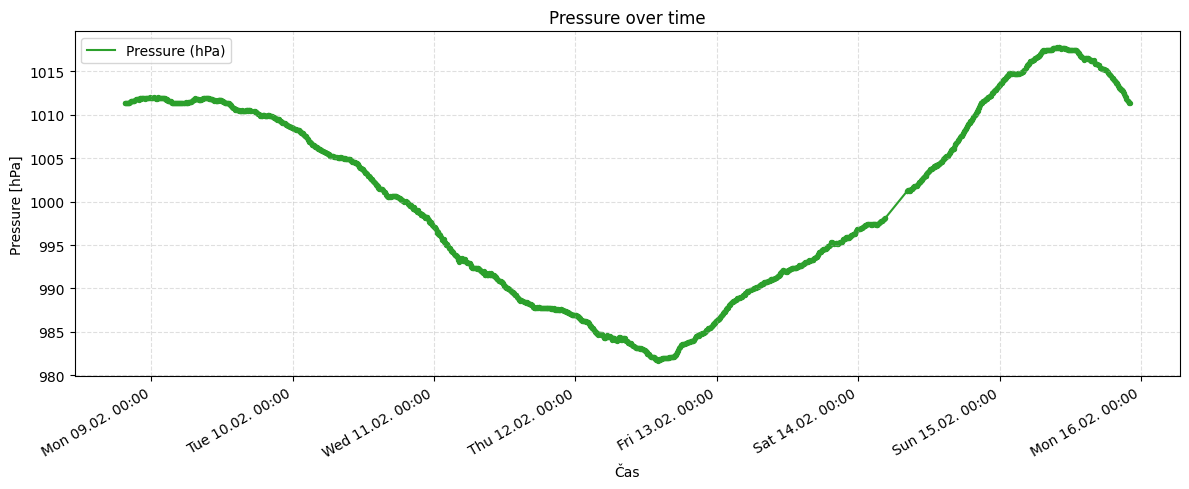

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# -----------------------------
# GRAF TLAKU
# -----------------------------
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_climate["time"], df_climate["pressure"],
        label="Pressure (hPa)", color="tab:green", linewidth=1.5)

ax.scatter(df_climate["time"], df_climate["pressure"], s=8, color="tab:green")

ax.set_title("Pressure over time")
ax.set_xlabel("Čas")
ax.set_ylabel("Pressure [hPa]")
ax.grid(True, linestyle="--", alpha=0.4)
ax.legend()

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
plt.show()



## Teplota v prádelně

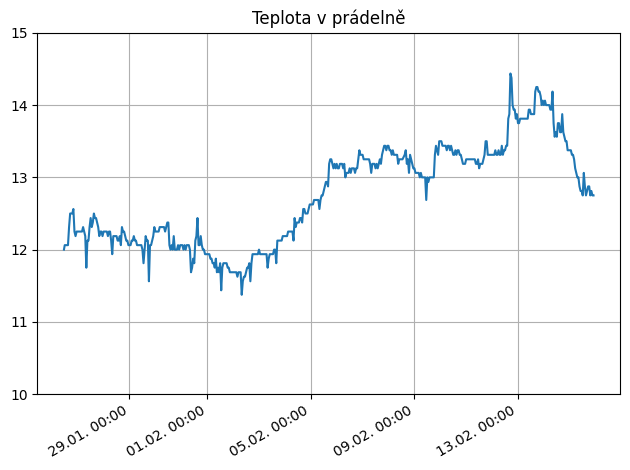

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# import mplcursors

df_pradelna = pd.read_csv("teplota_pradelna.csv", header=None, names=["cas", "tepl"])
# df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], errors="coerce")
df_pradelna["cas"] = pd.to_datetime(df_pradelna["cas"], format="%Y-%m-%d %H:%M:%S", errors="coerce")
df_pradelna["tepl"] = pd.to_numeric(df_pradelna["tepl"], errors="coerce")
df_pradelna = df_pradelna.dropna().sort_values("cas").drop_duplicates("cas")

fig, ax = plt.subplots()

ax.set_ylim(10, 15)
ax.set_title("Teplota v prádelně")

ax.plot(df_pradelna["cas"], df_pradelna["tepl"], linestyle="-", marker=None)
# ax.plot(df_pradelna["cas"], df_pradelna["tepl"], marker=".")
# ax.scatter(df_pradelna["cas"], df_pradelna["tepl"], s=5)

ax.grid()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d.%m. %H:%M'))
fig.autofmt_xdate()

plt.tight_layout()
# mplcursors.cursor(hover=True)
plt.show()


